In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
from scipy.spatial import distance
import math
import random
from IPython.display import display, clear_output

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Setting Up**

In [2]:
df_2030 = pd.read_csv('2030_Stations_and_Coordinates.csv')
df_2030["Station"] = df_2030["Station"].str.replace(" ", "_")
df_2030 = df_2030.dropna(subset=['Station'])
df_2030.loc[df_2030['Traffic'].notna(), 'Traffic'] = df_2030.loc[df_2030['Traffic'].notna(), 'Traffic'].astype(int)

display(df_2030)

,ID,Station,Traffic,Latitude,Longitude,First Line,Second Line,Third Line,Fourth Line,Fifth Line
0,1.0,GARE_DU_NORD,34503097.0,48.880556,2.355000,4,5,NaN,NaN,NaN
1,2.0,SAINT-LAZARE,33128384.0,48.875490,2.326640,3,9,12,13,14.0
2,3.0,GARE_DE_LYON,28640475.0,48.844722,2.373889,1,14,A,NaN,NaN
3,4.0,MONTPARNASSE-BIENVENUE,20407224.0,48.843466,2.323072,4,6,12,13,NaN
4,5.0,GARE_DE_L'EST,15538471.0,48.876111,2.358333,4,5,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
363,364.0,PALAISEAU,NaN,48.717388,2.245835,18,NaN,NaN,NaN,NaN
364,365.0,MASSY-PALAISEAU,NaN,48.724722,2.258333,18,NaN,NaN,NaN,NaN
365,366.0,MASSY_OPERA,NaN,48.731402,2.290821,18,NaN,NaN,NaN,NaN
366,367.0,ANTONYPOLE,NaN,48.733904,2.313677,18,NaN,NaN,NaN,NaN


## **Adding Timing to the Network**

In [3]:
df_time_between_stops = pd.read_csv("2030 Time Between Stops By Line.csv")
display(df_time_between_stops)

# Create a dictionary mapping line numbers to travel times
line_to_time = dict(zip(df_time_between_stops["Line"], df_time_between_stops["Time Between Stops (mins)"]))

,Line,Time Between Stops (mins)
0,1.0,1.500
1,2.0,1.375
2,3.0,1.292
3,3.5,1.000
4,4.0,1.250
5,5.0,1.619
6,6.0,1.269
7,7.0,1.424
8,7.5,1.000
9,8.0,1.378


Unique Metro Lines: {1, 2, 3, 4, 5, 6, 7, 8, 9, 7.5, 11, 12, 13, 14, 10, 3.5, 15, 16, 17, 18}


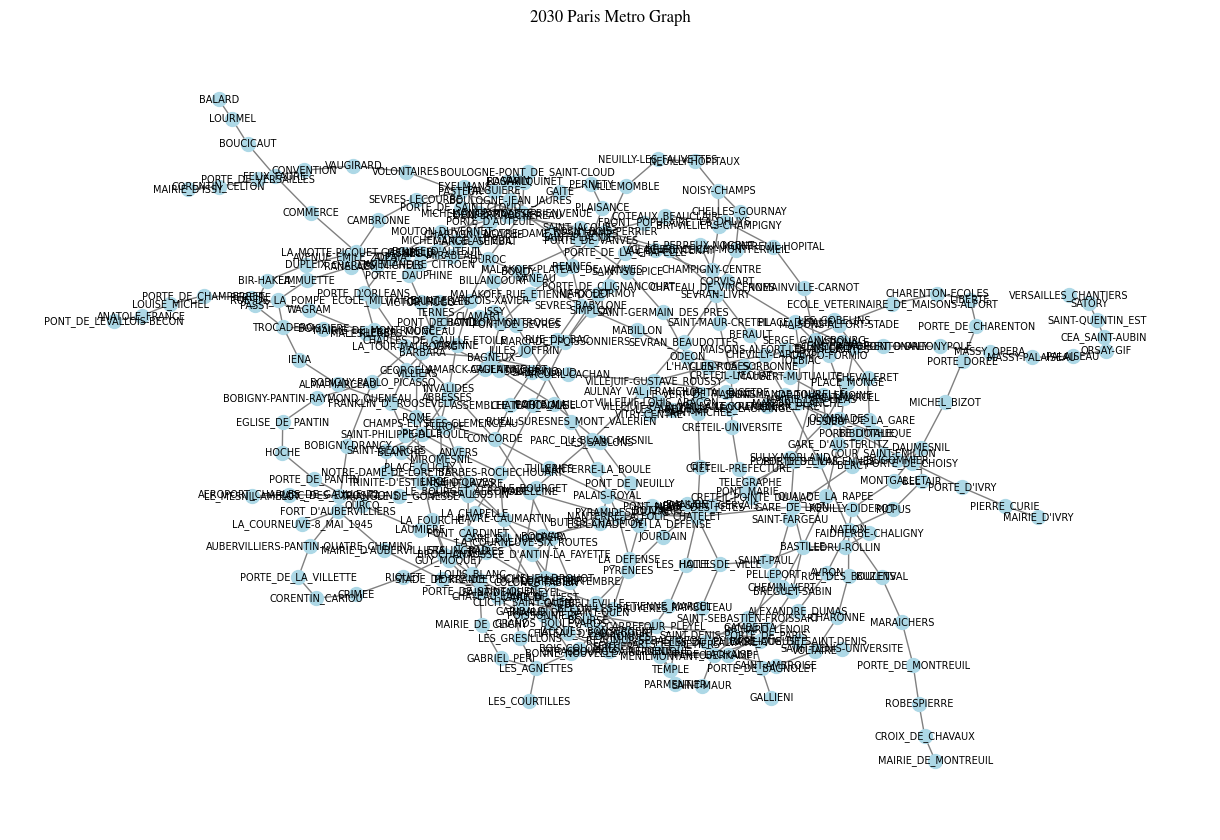

# of edges: 442


In [5]:
# Initialize an empty graph
G = nx.Graph()

# Initialize an empty set to store metro lines
metro_lines = set()

# Read the graph file manually and parse edges
with open("2030_graph_all_lines.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split(" ", 2)  # Split into first two parts + label dictionary
        if len(parts) == 3:
            node1, node2, attr_str = parts
            try:
                # Convert the attribute string into a dictionary
                attr_dict = eval(attr_str)  # Be cautious with eval() if the file is untrusted

                G.add_edge(node1, node2, **attr_dict)
            except SyntaxError:
                print(f"Skipping invalid line: {line.strip()}")

# Add traversal time as an edge attribute based on the line number
for u, v, data in G.edges(data=True):
    line = data.get("label")
    if line in line_to_time:
        G[u][v]["time"] = line_to_time[line]  # Assign travel time

# Extract all unique Metro lines from edge attributes
for edge in G.edges(data=True):
    line = edge[2].get("label")
    if line:
        metro_lines.add(line)

print(f"Unique Metro Lines: {metro_lines}")  # Print to check

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=7)
plt.title("2030 Paris Metro Graph")
plt.show()
print("# of edges:", G.number_of_edges())

In [6]:
def calculate_travel_time(graph, start_node, end_node):
  """Calculates the shortest travel time between two nodes.

  Args:
    graph: The networkx graph.
    start_node: The starting node.
    end_node: The destination node.

  Returns:
    The shortest travel time or None if no path is found.
  """
  try:
    shortest_path = nx.dijkstra_path(graph, source=start_node, target=end_node, weight="time")
    total_time = nx.path_weight(graph, shortest_path, weight="time")
    return total_time
  except nx.NetworkXNoPath:
    return None  # No path found

# Example usage:
start_node = "MAIRIE_DE_MONTREUIL"
end_node = "ROBESPIERRE"
travel_time = calculate_travel_time(G, start_node, end_node)

if travel_time is not None:
  print(f"Shortest travel time from {start_node} to {end_node}: {travel_time} minutes")
else:
  print(f"No path found between {start_node} and {end_node}")

Shortest travel time from MAIRIE_DE_MONTREUIL to ROBESPIERRE: 2.778 minutes


## **Locations of the Stations**

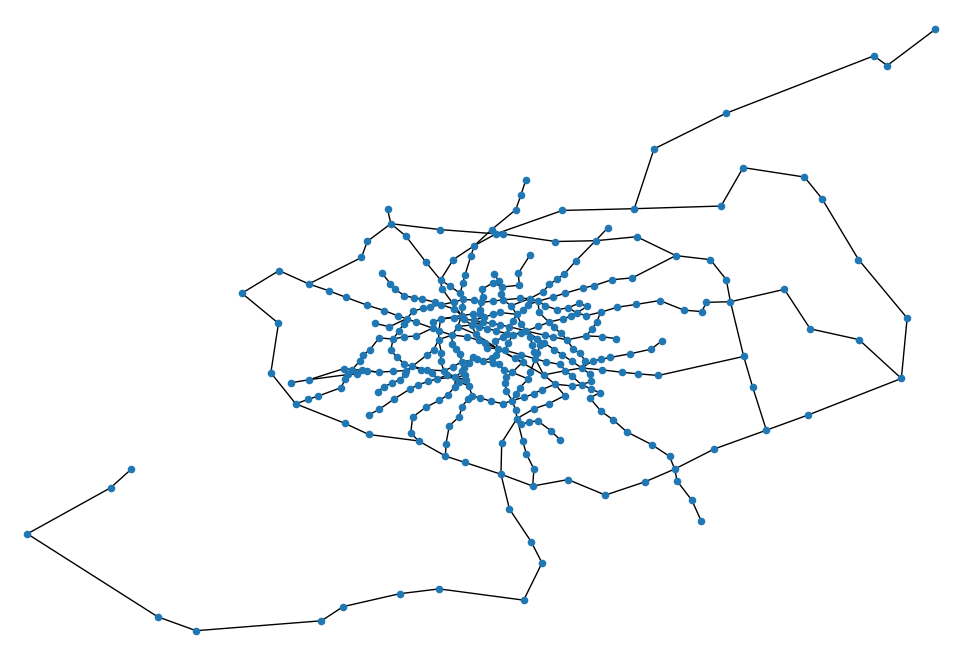

# of stations: 368


In [7]:
# Create a dictionary where keys are station names and values are (latitude, longitude) tuples
station_coordinates = {}
for index, row in df_2030.iterrows():
    station_coordinates[row['Station']] = (row['Longitude'], row['Latitude'])

plt.figure(figsize=(12, 8))  # Adjust the size as needed
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Extract longitude and latitude values from df1 to lists
longitude = df_2030['Longitude'].tolist()
latitude = df_2030['Latitude'].tolist()

plt.xlim([min(longitude) - 0.01, max(longitude) + 0.02])
plt.ylim([min(latitude) - 0.01 , max(latitude) + 0.01])
nx.draw(G, station_coordinates, node_size = 20)
plt.show()  # Display the visualization

print("# of stations:", G.number_of_nodes())

## **Estimating the Traffic of the 2030 Network and Updating df_2030**

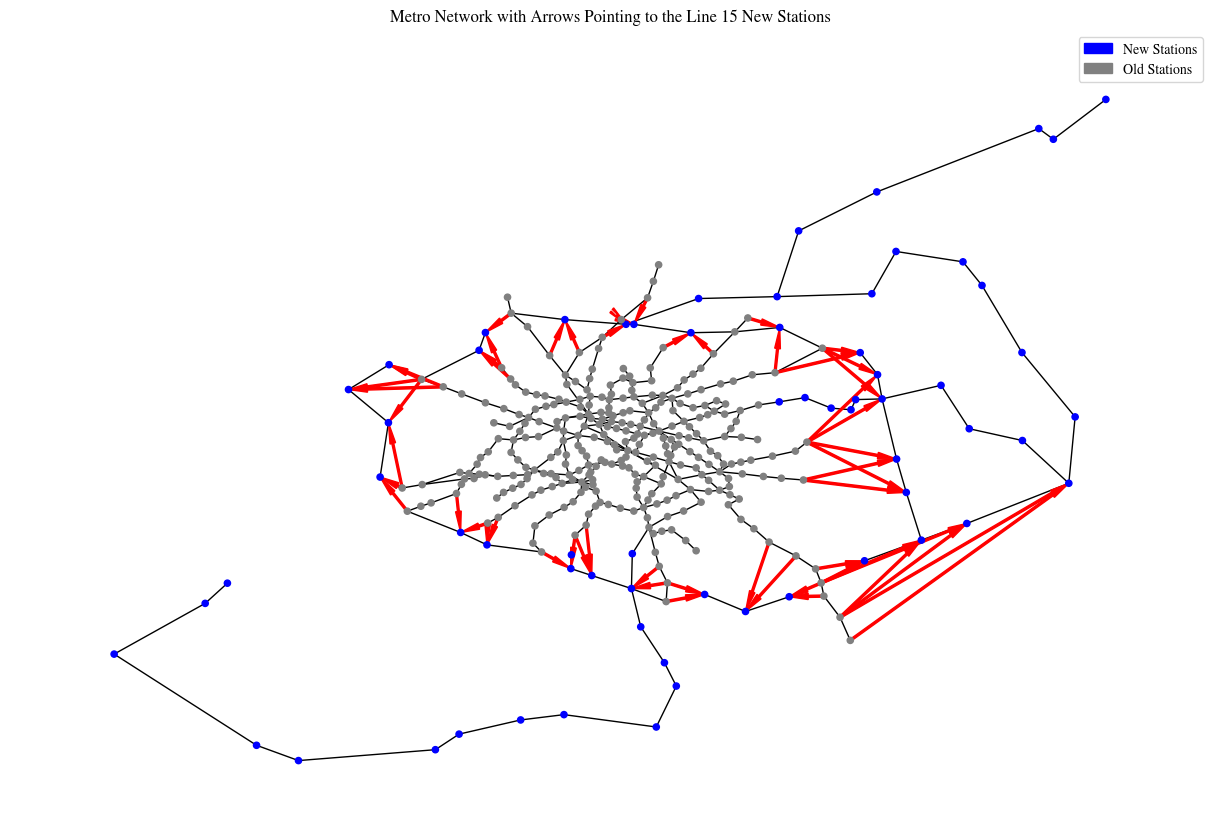

In [8]:
# Classify stations
nan_stations = df_2030[df_2030['Traffic'].isnull()]['Station'].tolist()
new_stations = set(nan_stations)  # Convert to a set for efficient lookup

# Get all stations from df_2030
all_stations = set(df_2030['Station'].tolist())

# Calculate old_stations (all stations that are not new stations)
old_stations = all_stations - new_stations

m = 2  # Number of old stations that each new station is stealing

# Compute distance between new stations and old stations
def find_nearest_old_stations(new_station, m):
    new_coord = station_coordinates[new_station]
    distances = [(old, distance.euclidean(new_coord, station_coordinates[old])) for old in old_stations]
    distances.sort(key=lambda x: x[1])  # Sort by distance
    return [station for station, _ in distances[:m]]

line_15_stations = df_2030[
    df_2030[['First Line', 'Second Line', 'Third Line', 'Fourth Line', 'Fifth Line']].apply(lambda row: any(str(val) == '15' for val in row.values), axis=1)
]['Station'].tolist()

# Visualization
plt.figure(figsize=(12, 8))  # Adjust the size as needed
pos = {station: (coord[0], coord[1]) for station, coord in station_coordinates.items()}
nx.draw(G, pos, with_labels=False, node_color=["blue" if n in new_stations else "gray" for n in G.nodes], edge_color='black', node_size = 20)

for new_station in new_stations:
    if new_station in line_15_stations:
        nearest_old_stations = find_nearest_old_stations(new_station, m)
        for old_station in nearest_old_stations:
          old_coord = station_coordinates[old_station]
          new_coord = station_coordinates[new_station]

          # Draw arrow
          plt.arrow(old_coord[0], old_coord[1],
                          new_coord[0] - old_coord[0], new_coord[1] - old_coord[1],
                          head_width=0.003, head_length=0.01, fc='red', ec='red', length_includes_head=True, width=0.001)

# Create legend elements
blue_patch = mpatches.Patch(color='blue', label='New Stations')
grey_patch = mpatches.Patch(color='grey', label='Old Stations')

# Add the legend to the plot
plt.legend(handles=[blue_patch, grey_patch])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Metro Network with Arrows Pointing to the Line 15 New Stations")
plt.show()

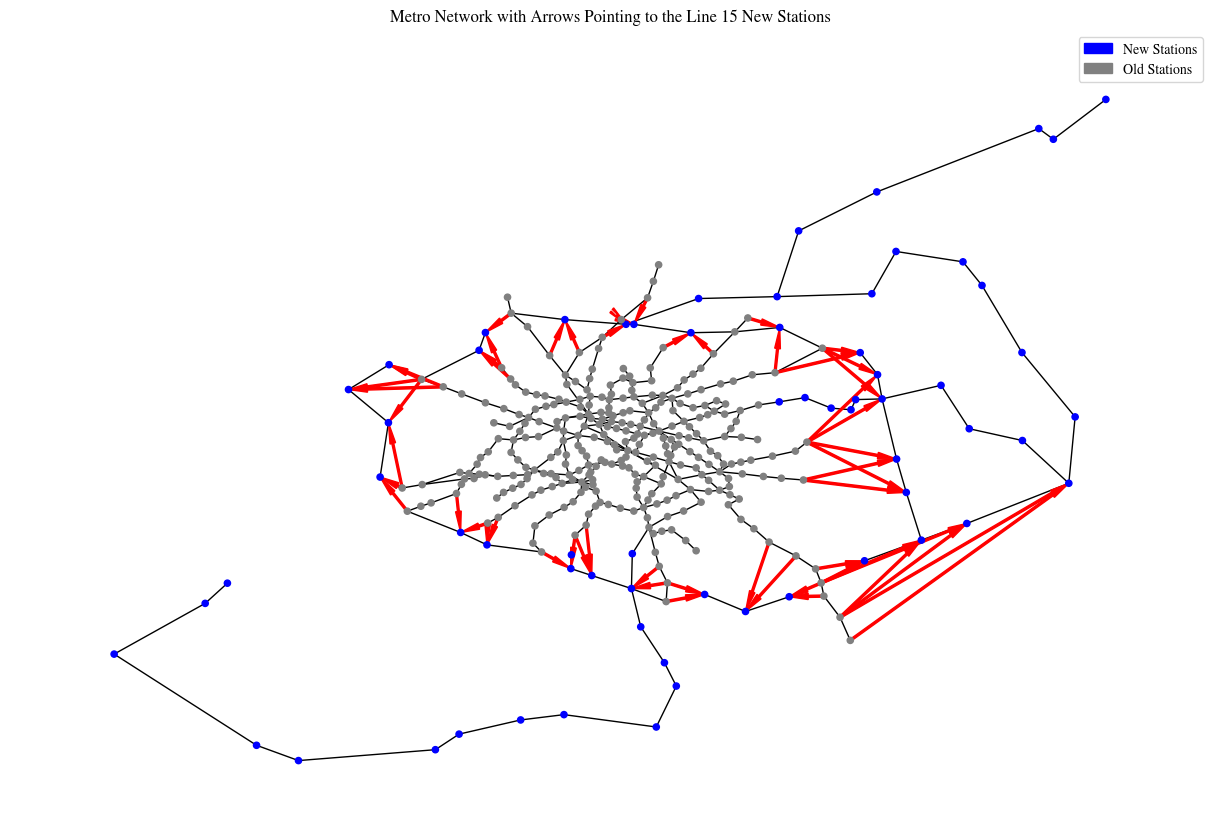

In [9]:
# Create a dictionary to map station names to their traffic values from df_2030
station_traffic = df_2030.set_index('Station')['Traffic'].to_dict()

# Assign traffic values to old nodes only
for node in G.nodes():
    if node in old_stations:  # Check if the node is an old station
        G.nodes[node]['traffic'] = station_traffic[node] # Assign traffic from df_2030

# Compute distance between new stations and old stations
def find_nearest_old_stations(new_station, m):
    new_coord = station_coordinates[new_station]
    distances = [(old, distance.euclidean(new_coord, station_coordinates[old])) for old in old_stations]
    distances.sort(key=lambda x: x[1])  # Sort by distance
    return [station for station, _ in distances[:m]]

# Redistribute traffic from old stations to new stations only in line 15_stations according to the arrows
for new_station in line_15_stations:
    # Find old stations that will point to the new station
    nearest_old_stations = find_nearest_old_stations(new_station, m)

    # Calculate traffic to be redistributed
    traffic_to_redistribute = 0
    for old_station in nearest_old_stations:
        traffic_to_redistribute += G.nodes[old_station]['traffic'] / (m + 1)

    # Redistribute traffic
    G.nodes[new_station]['traffic'] = traffic_to_redistribute
    for old_station in nearest_old_stations:
        G.nodes[old_station]['traffic'] -= G.nodes[old_station]['traffic'] / (m + 1)

# Visualization
plt.figure(figsize=(12, 8))  # Adjust the size as needed
pos = {station: (coord[0], coord[1]) for station, coord in station_coordinates.items()}
nx.draw(G, pos, with_labels=False, node_color=["blue" if n in new_stations else "gray" for n in G.nodes], edge_color='black', node_size = 20)

for new_station in new_stations:
    if new_station in line_15_stations:
        nearest_old_stations = find_nearest_old_stations(new_station, m)
        for old_station in nearest_old_stations:
          old_coord = station_coordinates[old_station]
          new_coord = station_coordinates[new_station]

          # Draw arrow
          plt.arrow(old_coord[0], old_coord[1],
                          new_coord[0] - old_coord[0], new_coord[1] - old_coord[1],
                          head_width=0.003, head_length=0.01, fc='red', ec='red', length_includes_head=True, width=0.001)

def meters_to_degrees(meters, latitude):
  """Converts meters to degrees of latitude at a given latitude."""
  return meters / (111.32 * 1000 * math.cos(math.radians(latitude)))

# Create legend elements
blue_patch = mpatches.Patch(color='blue', label='New Stations')
grey_patch = mpatches.Patch(color='grey', label='Old Stations')

# Add the legend to the plot
plt.legend(handles=[blue_patch, grey_patch])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Metro Network with Arrows Pointing to the Line 15 New Stations")
plt.show()

In [10]:
# Create a DataFrame for the table

# Create a dictionary to store the original traffic values
original_traffic = df_2030.set_index('Station')['Traffic'].to_dict()

# Create a DataFrame for the table
data = []
for node in G.nodes():
    original = original_traffic[node]  # Get original traffic
    new = G.nodes[node].get('traffic', 0)  # Get redistributed traffic (if available, else 0)
    data.append([node, original, new])

df_traffic_comparison = pd.DataFrame(data, columns=['Station ID', '2021 Traffic', '2030 Traffic'])

# Convert columns to numeric and suppress scientific notation
df_traffic_comparison['2030 Traffic'] = pd.to_numeric(df_traffic_comparison['2030 Traffic']).astype(int)

# Rename "Traffic" column in df_2030 to "2021 Traffic"
df_traffic_comparison.rename(columns={'Station ID': 'Station'}, inplace=True)

# Display the table
display(df_traffic_comparison)

# Download as a CSV file
df_traffic_comparison.to_csv('df_traffic_comparison.csv', index=False)

,Station,2021 Traffic,2030 Traffic
0,REPUBLIQUE,11079708.0,11079708
1,TEMPLE,891858.0,891858
2,PARMENTIER,2037234.0,2037234
3,OBERKAMPF,3205110.0,3205110
4,STRASBOURG-SAINT-DENIS,6345770.0,6345770
...,...,...,...
363,PORTE_DAUPHINE,2021656.0,2021656
364,GEORGE_V,3842260.0,3842260
365,LES_SABLONS,3954920.0,3954920
366,PONT_DE_NEUILLY,4809503.0,4809503


In [11]:
# Rename "Traffic" column in df_2030 to "2021 Traffic"
df_2030.rename(columns={'Traffic': '2021 Traffic'}, inplace=True)

# Merge "2030 Traffic" column from df_traffic_comparison into df_2030
# Assuming both dataframes have a common key, such as "Station" or "ID"
df_2030 = df_2030.merge(df_traffic_comparison[['Station', '2030 Traffic']], on='Station', how='left')

# Reorder columns to place "2030 Traffic" right after "2021 Traffic"
columns_order = ['ID', 'Station', '2021 Traffic', '2030 Traffic'] + [col for col in df_2030.columns if col not in ['ID', 'Station', '2021 Traffic', '2030 Traffic']]
df_2030 = df_2030[columns_order]

# Add 'Station Capacity' column
df_2030["Station Capacity"] = df_2030.apply(
    lambda row: 2 * (row["2030 Traffic"] if pd.isna(row["2021 Traffic"]) else row["2021 Traffic"]),
    axis=1
)
display(df_2030)

,ID,Station,2021 Traffic,2030 Traffic,Latitude,Longitude,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Station Capacity
0,1.0,GARE_DU_NORD,34503097.0,34503097,48.880556,2.355000,4,5,NaN,NaN,NaN,69006194.0
1,2.0,SAINT-LAZARE,33128384.0,33128384,48.875490,2.326640,3,9,12,13,14.0,66256768.0
2,3.0,GARE_DE_LYON,28640475.0,28640475,48.844722,2.373889,1,14,A,NaN,NaN,57280950.0
3,4.0,MONTPARNASSE-BIENVENUE,20407224.0,20407224,48.843466,2.323072,4,6,12,13,NaN,40814448.0
4,5.0,GARE_DE_L'EST,15538471.0,15538471,48.876111,2.358333,4,5,7,NaN,NaN,31076942.0
...,...,...,...,...,...,...,...,...,...,...,...,...
363,364.0,PALAISEAU,NaN,0,48.717388,2.245835,18,NaN,NaN,NaN,NaN,0.0
364,365.0,MASSY-PALAISEAU,NaN,0,48.724722,2.258333,18,NaN,NaN,NaN,NaN,0.0
365,366.0,MASSY_OPERA,NaN,0,48.731402,2.290821,18,NaN,NaN,NaN,NaN,0.0
366,367.0,ANTONYPOLE,NaN,0,48.733904,2.313677,18,NaN,NaN,NaN,NaN,0.0


In [13]:
# Adding the 2030 Traffic values for lines that aren't line 15
df_2030_predicted_traffic_population = pd.read_csv('2030_Predicted_Traffic_Using_Population.csv')

# Replace 0 values in '2030 Traffic' column of df_2030 with corresponding values from df_2030_predicted_traffic_population
df_2030['2030 Traffic'] = df_2030.apply(
    lambda row: df_2030_predicted_traffic_population.loc[
        df_2030_predicted_traffic_population['Station'] == row['Station'], '2030 Traffic'
    ].values[0] if row['2030 Traffic'] == 0 else row['2030 Traffic'], axis=1
)

display(df_2030)

# Download as a CSV file
df_2030.to_csv('df_2030.csv', index=False)

,ID,Station,2021 Traffic,2030 Traffic,Latitude,Longitude,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Station Capacity
0,1.0,GARE_DU_NORD,34503097.0,34503097,48.880556,2.355000,4,5,NaN,NaN,NaN,69006194.0
1,2.0,SAINT-LAZARE,33128384.0,33128384,48.875490,2.326640,3,9,12,13,14.0,66256768.0
2,3.0,GARE_DE_LYON,28640475.0,28640475,48.844722,2.373889,1,14,A,NaN,NaN,57280950.0
3,4.0,MONTPARNASSE-BIENVENUE,20407224.0,20407224,48.843466,2.323072,4,6,12,13,NaN,40814448.0
4,5.0,GARE_DE_L'EST,15538471.0,15538471,48.876111,2.358333,4,5,7,NaN,NaN,31076942.0
...,...,...,...,...,...,...,...,...,...,...,...,...
363,364.0,PALAISEAU,NaN,26563097,48.717388,2.245835,18,NaN,NaN,NaN,NaN,0.0
364,365.0,MASSY-PALAISEAU,NaN,26563097,48.724722,2.258333,18,NaN,NaN,NaN,NaN,0.0
365,366.0,MASSY_OPERA,NaN,26563097,48.731402,2.290821,18,NaN,NaN,NaN,NaN,0.0
366,367.0,ANTONYPOLE,NaN,26563097,48.733904,2.313677,18,NaN,NaN,NaN,NaN,0.0


## **Simulating Metro Line Closures**

In [14]:
def update_node_with_lambda(G, lambda_dictionary):
  for node in G.nodes():
    G.nodes[node]["lambda"] = lambda_dictionary[node] / 200
  return G

def inputs(G_altered):
    for station in G_altered.nodes():
        probs = {}

        # Get shortest path lengths from the current station
        shortest_paths = nx.shortest_path_length(G_altered, source=station)

        # Buckets for different travel distances
        long_trip = []  # 10+ stops
        medium_trip = []  # 5-10 stops
        short_trip = []  # <5 stops

        for node, distance in shortest_paths.items():
            if node == station:
                continue  # Skip self
            if distance >= 10:
                long_trip.append(node)
            elif 5 <= distance < 10:
                medium_trip.append(node)
            else:
                short_trip.append(node)

        # Assign probabilities based on the given distribution
        total_nodes = len(long_trip) + len(medium_trip) + len(short_trip)

        if total_nodes > 0:
            p_long = 0.3 / max(1, len(long_trip))
            p_medium = 0.35 / max(1, len(medium_trip))
            p_short = 0.35 / max(1, len(short_trip))

            for node in long_trip:
                probs[node] = p_long
            for node in medium_trip:
                probs[node] = p_medium
            for node in short_trip:
                probs[node] = p_short

        # Normalize the probabilities to sum to 1
        total_prob = sum(probs.values())
        if total_prob > 0:
            probs = {k: v / total_prob for k, v in probs.items()}

        lambda_value = (lambda_dictionary[station] / 200)

        # Store in graph
        G_altered.nodes[station]["data"] = (probs, lambda_value)

    return G_altered

def simulate_arrivals(G, days):
    """Generates passenger arrivals at each station using a Poisson distribution."""
    arrivals = {}
    for station in G.nodes():
        _, lambda_value = G.nodes[station]["data"]
        arrivals[station] = np.random.poisson(lam=lambda_value, size=days)
    return arrivals

def simulate_passenger_journeys(G, daily_arrivals):
    journeys = []

    for station, arrivals in daily_arrivals.items():
        total_passengers = sum(arrivals)  # Total passengers arriving in the day

        for _ in range(total_passengers):
          # Get the probability distribution for the current station
          probs, _ = G.nodes[station]["data"]

          # Choose a destination based on the probability distribution
          if probs:  # Check if probs is not empty
              destinations = list(probs.keys())
              probabilities = list(probs.values())
              destination = np.random.choice(destinations, p=probabilities)
          else:
              # If probs is empty, choose a random destination (as a fallback)
              destination = np.random.choice([s for s in stations if s != station])

            # Check if a path exists
          try:
            path_nodes = nx.shortest_path(G, source=station, target=destination)
            path_edges = [(path_nodes[i], path_nodes[i + 1]) for i in range(len(path_nodes) - 1)]
            path_line_number = nx.get_edge_attributes(G, "label")
            path_length = nx.get_edge_attributes(G, "length")
            journeys.append(path_nodes)
          except nx.NetworkXNoPath:
            print(f"No path found between {station} and {destination}. Skipping this journey.")
              # You can optionally handle this case differently, like choosing a new destination

    return journeys

def calculate_avg_transfers(G, results):
    """Calculates the average number of transfers that someone who starts at each station would have to make to get to their final destination."""

    station_transfers = {}  # Store total transfers for each starting station
    station_counts = {}    # Store the number of journeys starting from each station

    for person_id, journey in enumerate(results):
        start_station = journey[0]  # Get the starting station for this journey

        # If this is the first journey from this station, initialize counts
        station_transfers.setdefault(start_station, 0)
        station_counts.setdefault(start_station, 0)

        # Count the transfers for this journey (same logic as before)
        transfers = 0
        if len(journey) > 2:
            for i in range(len(journey) - 2):
                current_edge = (journey[i], journey[i + 1])
                next_edge = (journey[i + 1], journey[i + 2])
                if G.get_edge_data(*current_edge).get("label") != G.get_edge_data(*next_edge).get("label"):
                    transfers += 1

        station_transfers[start_station] += transfers  # Add transfers for this journey
        station_counts[start_station] += 1           # Increment journey count for this station

    # Calculate averages
    avg_transfers = {}
    for station in station_transfers:
        avg_transfers[station] = station_transfers[station] / station_counts[station]

    return avg_transfers

def calculate_path_time(G, path):
  """Calculates the total travel time for a given path,
  including a 4.50-minute penalty for each transfer."""

  total_time = 0
  transfers = 0  # Initialize transfer count

  for i in range(len(path) - 1):
    u, v = path[i], path[i + 1]
    try:
      time = G[u][v]["time"]
      total_time += time

      # Check for transfers (if not the first edge)
      if i > 0:
        current_line = G[path[i - 1]][path[i]].get("label")  # Get the line of the previous edge
        next_line = G[u][v].get("label")  # Get the line of the current edge

        if current_line != next_line:  # If lines are different, it's a transfer
          transfers += 1

    except KeyError:
      print(f"Warning: No time attribute found for edge ({u}, {v}). Skipping...")

  # Add transfer penalty to total time
  total_time += transfers * 4.50
  return total_time

def remove_metro_line(graph, line):
    """Removes a metro line from the graph.

    Args:
        graph: The networkx graph.
        line: The metro line to remove (e.g., '1', '2', etc.).

    Returns:
        A new graph with the specified metro line removed.
    """

    G_temp = graph.copy()  # Create a copy of the graph

    # Identify edges associated with the metro line
    edges_to_remove = [(u, v) for u, v, data in G_temp.edges(data=True) if data.get("label") == line]

    # Remove the edges
    G_temp.remove_edges_from(edges_to_remove)

    # Remove isolated nodes (nodes with no edges)
    G_temp.remove_nodes_from(list(nx.isolates(G_temp)))

    return G_temp  # Return the modified graph

# The inputs/outputs of the function

lambda_dictionary = dict(zip(df_2030['Station'], df_2030['2030 Traffic'] / 365))
path_times = {}
sum_path_time = {}
passengers = {}

for line in metro_lines:
  G_altered = remove_metro_line(G, line)
  # Draw the graph after removing the metro line
  plt.figure(figsize=(12, 8))
  nx.draw(G_altered, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=7)
  plt.title(f"Paris Metro Graph - After Closing Line {line}")

  plt.show()
  print("# of edges:", G_altered.number_of_edges())
  print("# of nodes:", G_altered.number_of_nodes())

  # Apply the functions to the graph
  G_altered = inputs(G_altered)
  stations = list(G_altered.nodes())
  daily_arrivals = simulate_arrivals(G_altered, 1)
  G_altered = update_node_with_lambda(G_altered, lambda_dictionary)
  results = simulate_passenger_journeys(G_altered, daily_arrivals) # Run the simulation

  # Create a list to store the data for the DataFrame
  data_results = []
  for i, journey in enumerate(results):
    data_results.append({'person_id': i + 1, 'path': journey})  # Store the entire path

  # Create a DataFrame from the data
  df_results = pd.DataFrame(data_results)
  df_results['path_time'] = df_results['path'].apply(lambda path: calculate_path_time(G_altered, path))

  # Print the DataFrame
  display(df_results)

  sum_path_time[line] = df_results['path_time'].sum()
  passengers[line] = len(df_results)
  average_path_time = df_results['path_time'].mean()
  print(f"Average Path Tim (mins): {average_path_time}")
  path_times[line] = average_path_time

  # Calculate and print the average transfers
  avg_transfers_result = calculate_avg_transfers(G_altered, results)
  print("The average # transfers a person who starts at each station needs to make to get to their destination")
  print(avg_transfers_result)


Output hidden; open in https://colab.research.google.com to view.

In [15]:
for line, avg_time in path_times.items():
    print(f"Line {line}: {avg_time:.3f}")

Line 1: 23.693
Line 2: 23.975
Line 3: 23.950
Line 4: 24.124
Line 5: 23.863
Line 6: 24.013
Line 7: 24.018
Line 8: 23.698
Line 9: 23.861
Line 7.5: 23.760
Line 11: 24.146
Line 12: 23.622
Line 13: 23.870
Line 14: 20.849
Line 10: 23.874
Line 3.5: 23.745
Line 15: 24.613
Line 16: 23.589
Line 17: 22.700
Line 18: 22.066


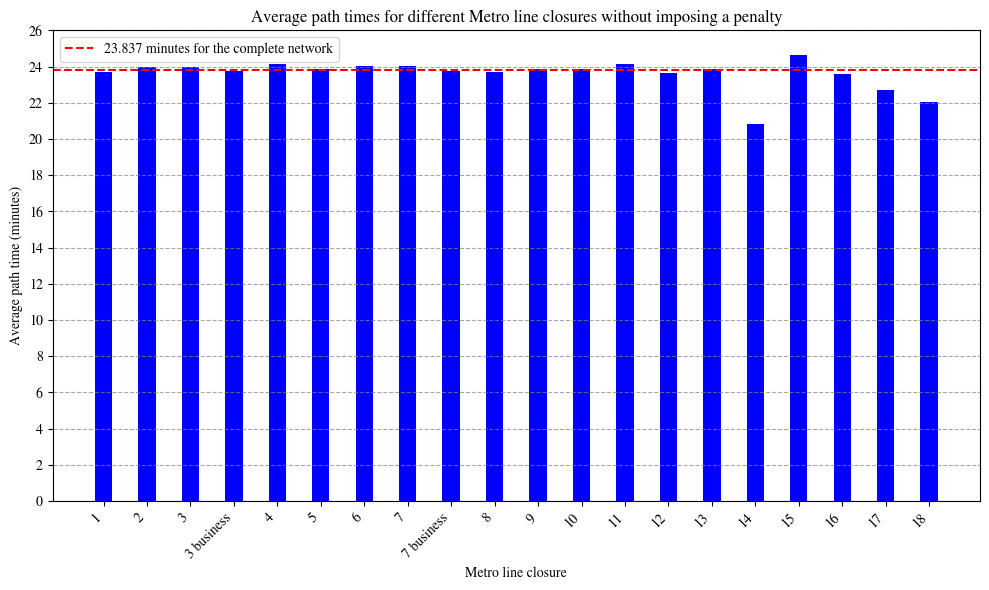

In [17]:
# Extract lines and average times from path_times
avg_times_no_penalty = list(path_times.values())
lines = list(path_times.keys())

# Replace "3.5" and "7.5" in lines list
lines = [str(line).replace("3.5", "3 business").replace("7.5", "7 business") for line in lines]

# Find the indices of "3" and "3 business"
index_3 = lines.index("3")
index_3_business = lines.index("3 business")

# Move "3 business" and its corresponding data to the correct position
lines.insert(index_3 + 1, lines.pop(index_3_business))
avg_times_no_penalty.insert(index_3 + 1, avg_times_no_penalty.pop(index_3_business))

# Find the indices of "7" and "7 business"
index_7 = lines.index("7")
index_7_business = lines.index("7 business")

# Move "7 business" and its corresponding data to the correct position
lines.insert(index_7 + 1, lines.pop(index_7_business))
avg_times_no_penalty.insert(index_7 + 1, avg_times_no_penalty.pop(index_7_business))

# Find the indices of "9", "10", and "11"
index_9 = lines.index("9")
index_10 = lines.index("10")
index_11 = lines.index("11")

# Move "10" and its corresponding data to the correct position
lines.insert(index_9 + 1, lines.pop(index_10))  # Insert "10" after "9"
avg_times_no_penalty.insert(index_9 + 1, avg_times_no_penalty.pop(index_10))  # Insert "10" data after "9" data

# Create evenly spaced x-axis positions
x_pos = np.arange(len(lines))

# Create the bar graph with fixed width
plt.figure(figsize=(10, 6))
plt.bar(x_pos, avg_times_no_penalty, color='blue', width=0.4)  # Set width to 0.8

# Add horizontal line (threshold)
threshold_value = 23.83743057494656  # The threshold value
plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'{threshold_value:.3f} minutes for the complete network')

# Customize the graph
plt.xlabel("Metro line closure")
plt.ylabel("Average path time (minutes)")
plt.title("Average path times for different Metro line closures without imposing a penalty")
plt.xticks(x_pos, lines, rotation=45, ha='right')  # Label each bar
plt.yticks(np.arange(0, max(avg_times_no_penalty) + 2, 2))  # Set y-axis ticks every 2 units
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)  # Add horizontal grid lines
plt.legend()  # Show legend including threshold line

# Display the graph
plt.tight_layout()
plt.savefig("no_penalty_closures.pdf", bbox_inches='tight')

In [18]:
# Remove np.float64 and convert to regular floats
modified_sum_path_time = {k: float(v) for k, v in sum_path_time.items()}
modified_sum_path_time = {str(k): v for k, v in modified_sum_path_time.items()}
passengers = {str(k): v for k, v in passengers.items()}

print(modified_sum_path_time)
print(passengers)

{'1': 489074.19999999995, '2': 492292.543, '3': 499766.47500000003, '4': 481464.999, '5': 494364.57100000005, '6': 496286.01900000003, '7': 492198.961, '8': 487866.25600000005, '9': 486239.514, '7.5': 510230.377, '11': 479297.82, '12': 492278.77900000004, '13': 492989.71900000004, '14': 407020.574, '10': 500621.18600000005, '3.5': 499530.122, '15': 510310.301, '16': 477656.79500000004, '17': 454774.541, '18': 393516.145}
{'1': 20642, '2': 20534, '3': 20867, '4': 19958, '5': 20717, '6': 20667, '7': 20493, '8': 20587, '9': 20378, '7.5': 21474, '11': 19850, '12': 20840, '13': 20653, '14': 19522, '10': 20969, '3.5': 21037, '15': 20733, '16': 20249, '17': 20034, '18': 17834}


In [20]:
df_traffic_by_line = pd.read_csv("df_line_data_2030.csv")
display(df_traffic_by_line)

,Metro Line,Total Annual 2030 Traffic,Total Daily 2030 Traffic,Total Daily 2030 Traffic / 100,Total Daily 2030 Traffic / 200
0,1,7.799481e+07,213684.408813,2136.844088,1068.422044
1,10,3.058428e+07,83792.544292,837.925443,418.962721
2,11,1.195350e+08,327493.252694,3274.932527,1637.466263
3,12,5.885409e+07,161244.071142,1612.440711,806.220356
4,13,7.140078e+07,195618.562466,1956.185625,978.092812
5,14,1.795071e+08,491800.370137,4918.003701,2459.001851
6,15,3.875955e+07,106190.544749,1061.905447,530.952724
7,16,7.941620e+07,217578.639269,2175.786393,1087.893196
8,17,6.762825e+07,185282.865753,1852.828658,926.414329
9,18,2.523494e+08,691368.278082,6913.682781,3456.841390


In [21]:
df_traffic_by_line['Metro Line'] = df_traffic_by_line['Metro Line'].replace("3bis", "3.5")
df_traffic_by_line['Metro Line'] = df_traffic_by_line['Metro Line'].replace("7bis", "7.5")
df_traffic_by_line['Metro Line'] = df_traffic_by_line['Metro Line'].astype(str)  # Convert to strings

# Add 'Sum Path Time' column
df_traffic_by_line['Sum Path Time'] = df_traffic_by_line['Metro Line'].map(modified_sum_path_time)

# Add 'Passengers' column
df_traffic_by_line['Passengers On This Line'] = df_traffic_by_line['Metro Line'].map(passengers)

display(df_traffic_by_line)

,Metro Line,Total Annual 2030 Traffic,Total Daily 2030 Traffic,Total Daily 2030 Traffic / 100,Total Daily 2030 Traffic / 200,Sum Path Time,Passengers On This Line
0,1,7.799481e+07,213684.408813,2136.844088,1068.422044,489074.200,20642
1,10,3.058428e+07,83792.544292,837.925443,418.962721,500621.186,20969
2,11,1.195350e+08,327493.252694,3274.932527,1637.466263,479297.820,19850
3,12,5.885409e+07,161244.071142,1612.440711,806.220356,492278.779,20840
4,13,7.140078e+07,195618.562466,1956.185625,978.092812,492989.719,20653
5,14,1.795071e+08,491800.370137,4918.003701,2459.001851,407020.574,19522
6,15,3.875955e+07,106190.544749,1061.905447,530.952724,510310.301,20733
7,16,7.941620e+07,217578.639269,2175.786393,1087.893196,477656.795,20249
8,17,6.762825e+07,185282.865753,1852.828658,926.414329,454774.541,20034
9,18,2.523494e+08,691368.278082,6913.682781,3456.841390,393516.145,17834


In [22]:
# Impose a penalty

df_traffic_by_line['Avg Time With a Penalty'] = df_traffic_by_line.apply(lambda row:
    ((row['Total Daily 2030 Traffic / 200'] * 48.5) + row['Sum Path Time']) / (row['Passengers On This Line'] + (row['Total Daily 2030 Traffic / 200']))
    if row['Metro Line'] in ['15', '16', '17', '18']
    else ((row['Total Daily 2030 Traffic / 200'] * 39.75) + row['Sum Path Time']) / (row['Passengers On This Line'] + (row['Total Daily 2030 Traffic / 200']))
    if row['Metro Line'] == '14'
    else ((row['Total Daily 2030 Traffic / 200'] * 35.375) + row['Sum Path Time']) / (row['Passengers On This Line'] + (row['Total Daily 2030 Traffic / 200']))
    if row['Metro Line'] == '11'
    else ((row['Total Daily 2030 Traffic / 200'] * 31) + row['Sum Path Time']) / (row['Passengers On This Line'] + (row['Total Daily 2030 Traffic / 200'])),
    axis=1
)

# Create the new column

df_traffic_by_line['Avg Time With a Penalty'] = (
    (df_traffic_by_line['Total Daily 2030 Traffic / 200'] * 31) + df_traffic_by_line['Sum Path Time']
) / (
    df_traffic_by_line['Passengers On This Line'] + (df_traffic_by_line['Total Daily 2030 Traffic / 200'])
)

# Print or display the DataFrame to see the new column
display(df_traffic_by_line)

,Metro Line,Total Annual 2030 Traffic,Total Daily 2030 Traffic,Total Daily 2030 Traffic / 100,Total Daily 2030 Traffic / 200,Sum Path Time,Passengers On This Line,Avg Time With a Penalty
0,1,7.799481e+07,213684.408813,2136.844088,1068.422044,489074.200,20642,24.052747
1,10,3.058428e+07,83792.544292,837.925443,418.962721,500621.186,20969,24.013930
2,11,1.195350e+08,327493.252694,3274.932527,1637.466263,479297.820,19850,24.668300
3,12,5.885409e+07,161244.071142,1612.440711,806.220356,492278.779,20840,23.896625
4,13,7.140078e+07,195618.562466,1956.185625,978.092812,492989.719,20653,24.192518
5,14,1.795071e+08,491800.370137,4918.003701,2459.001851,407020.574,19522,21.984877
6,15,3.875955e+07,106190.544749,1061.905447,530.952724,510310.301,20733,24.772903
7,16,7.941620e+07,217578.639269,2175.786393,1087.893196,477656.795,20249,23.967008
8,17,6.762825e+07,185282.865753,1852.828658,926.414329,454774.541,20034,23.066977
9,18,2.523494e+08,691368.278082,6913.682781,3456.841390,393516.145,17834,23.516132


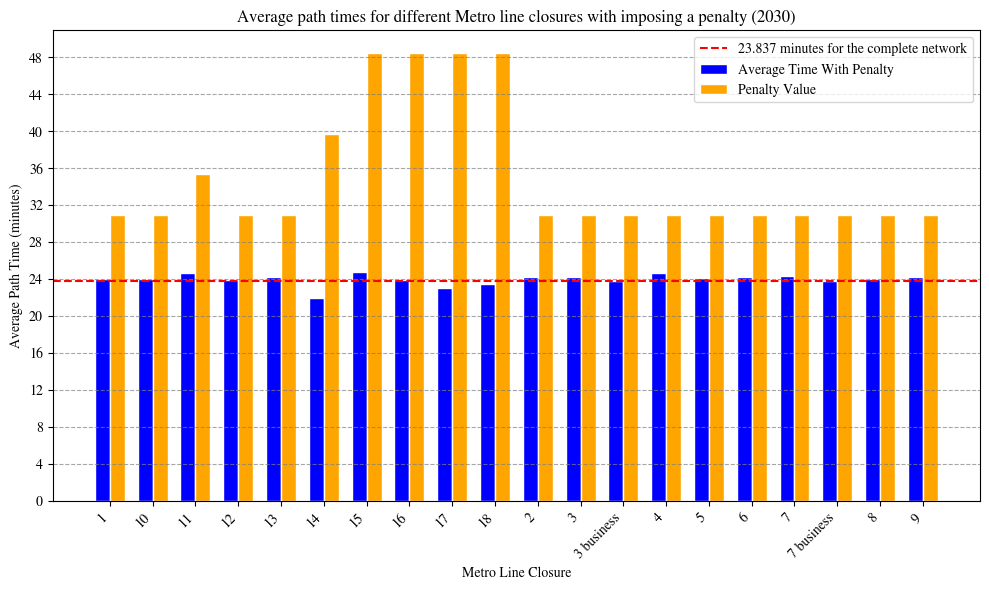

In [25]:
# Extract lines and average times from path_times
avg_times_with_penalty = df_traffic_by_line['Avg Time With a Penalty'].tolist()
lines = df_traffic_by_line['Metro Line'].tolist()

# Calculate values for the second bar
second_bar_values = df_traffic_by_line.apply(lambda row:
    48.5 if row['Metro Line'] in ['15', '16', '17', '18']
    else 39.75 if row['Metro Line'] == '14'
    else 35.375 if row['Metro Line'] == '11'
    else 31,
    axis=1
).tolist()

# Set width of each bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(lines))
r2 = [x + bar_width for x in r1]

# Replace "3.5" and "7.5" in lines list
lines = [str(line).replace("3.5", "3 business").replace("7.5", "7 business") for line in lines]

# Find the indices of "3" and "3 business"
index_3 = lines.index("3")
index_3_business = lines.index("3 business")

# Move "3 business" and its corresponding data to the correct position
# lines.insert(index_3 + 1, lines.pop(index_3_business))
# avg_times.insert(index_3 + 1, avg_times.pop(index_3_business))

# Find the indices of "7" and "7 business"
index_7 = lines.index("7")
index_7_business = lines.index("7 business")

# Move "7 business" and its corresponding data to the correct position
# lines.insert(index_7 + 1, lines.pop(index_7_business))
# avg_times.insert(index_7 + 1, avg_times.pop(index_7_business))

# Find the indices of "9", "10", and "11"
# index_9 = lines.index("9")
# index_10 = lines.index("10")
# index_11 = lines.index("11")

# Move "10" and its corresponding data to the correct position
# lines.insert(index_9 + 1, lines.pop(index_10))  # Insert "10" after "9"
# avg_times.insert(index_9 + 1, avg_times.pop(index_10))  # Insert "10" data after "9" data

# Create evenly spaced x-axis positions
x_pos = np.arange(len(lines))

# Create the bar graph with fixed width
plt.figure(figsize=(10, 6))
plt.bar(r1, avg_times_with_penalty, color='blue', width=bar_width, edgecolor='white', label='Average Time With Penalty')
plt.bar(r2, second_bar_values, color='orange', width=bar_width, edgecolor='white', label='Penalty Value')

# Add horizontal line (threshold)
threshold_value = 23.83743057494656  # The threshold value
plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'{threshold_value:.3f} minutes for the complete network')

# Customize the graph
plt.xlabel("Metro Line Closure")
plt.ylabel("Average Path Time (minutes)")
plt.title("Average path times for different Metro line closures with imposing a penalty (2030)")

plt.xticks([r + bar_width/2 for r in range(len(lines))], lines, rotation=45, ha='right')

plt.yticks(np.arange(0, 52, 4)) # Corrected line: providing the ticks as a sequence with a step of 2
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)  # Add horizontal grid lines
plt.legend()  # Show legend including threshold line

# Display the graph
plt.tight_layout()
plt.show()

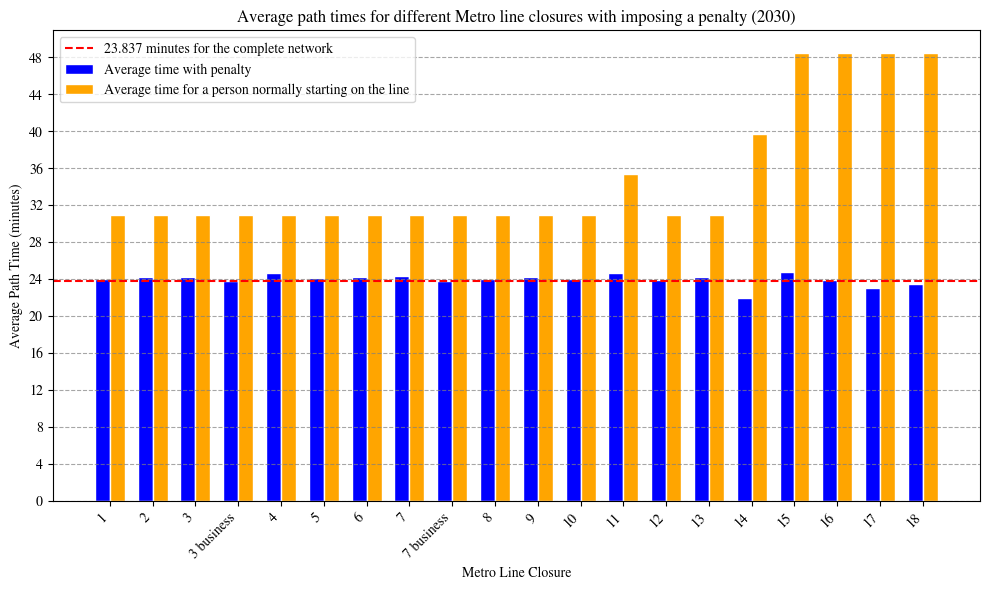

In [26]:
# Extract lines and average times from path_times
avg_times_with_penalty = df_traffic_by_line['Avg Time With a Penalty'].tolist()
lines = df_traffic_by_line['Metro Line'].tolist()

# Calculate values for the second bar
second_bar_values = df_traffic_by_line.apply(lambda row:
    48.5 if row['Metro Line'] in ['15', '16', '17', '18']
    else 39.75 if row['Metro Line'] == '14'
    else 35.375 if row['Metro Line'] == '11'
    else 31,
    axis=1
).tolist()

# Set width of each bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(lines))
r2 = [x + bar_width for x in r1]

# Replace "3.5" and "7.5" in lines list
lines = [str(line).replace("3.5", "3 business").replace("7.5", "7 business") for line in lines]

# Define the desired order of lines
desired_order = ['1', '2', '3', '3 business', '4', '5', '6', '7', '7 business', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']

# Reorder data based on desired_order
# Create a dictionary to map lines to their index in desired_order
order_mapping = {line: i for i, line in enumerate(desired_order)}

# Sort lines, avg_times_with_penalty, and second_bar_values based on order_mapping
sorted_indices = sorted(range(len(lines)), key=lambda i: order_mapping[lines[i]])
lines = [lines[i] for i in sorted_indices]
avg_times_with_penalty = [avg_times_with_penalty[i] for i in sorted_indices]
second_bar_values = [second_bar_values[i] for i in sorted_indices]


# Create evenly spaced x-axis positions
x_pos = np.arange(len(lines))

# Create the bar graph with fixed width
plt.figure(figsize=(10, 6))
plt.bar(r1, avg_times_with_penalty, color='blue', width=bar_width, edgecolor='white', label='Average time with penalty')
plt.bar(r2, second_bar_values, color='orange', width=bar_width, edgecolor='white', label='Average time for a person normally starting on the line')

# Add horizontal line (threshold)
threshold_value = 23.83743057494656  # The threshold value
plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'{threshold_value:.3f} minutes for the complete network')

# Customize the graph
plt.xlabel("Metro Line Closure")
plt.ylabel("Average Path Time (minutes)")
plt.title("Average path times for different Metro line closures with imposing a penalty (2030)")

plt.xticks([r + bar_width/2 for r in range(len(lines))], lines, rotation=45, ha='right')

plt.yticks(np.arange(0, 52, 4))  # Set y-axis ticks every 4 units
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)  # Add horizontal grid lines
plt.legend()  # Show legend including threshold line

# Display the graph
plt.tight_layout()
plt.savefig("penalty_closures.pdf", bbox_inches='tight')